# Feature Selection - Online News Popularity 
In this notebook I'll be modeling using a dataset on online news popularity for articles shared on mashable. The focus here will be on using feature selection methods and the comparison between them.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, f_classif

%matplotlib inline

In [3]:
df = pd.read_csv('./OnlineNewsPopularity.csv')

print(df.shape)
df.head()

(39644, 61)


url   timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...       731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...       731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...       731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...       731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/       731.0   

    n_tokens_title   n_tokens_content   n_unique_tokens   n_non_stop_words  \
0             12.0              219.0          0.663594                1.0   
1              9.0              255.0          0.604743                1.0   
2              9.0              211.0          0.575130                1.0   
3              9.0              531.0          0.503788                1.0   
4             13.0             1072.0          0.415646                1.0   

    n_non_stop_unique_tokens   num_hrefs   num_self_hrefs   num_imgs   ...     \
0                   0.815385         4.0              2.0        1.0   ...      
1                   0.791946         3.0              1.0        1.0   ...      
2                   0.663866         3.0              1.0        1.0   ...      
3                   0.665635         9.0              0.0        1.0   ...      
4                   0.540890        19.0             19.0       20.0   ...      

    min_positive_polarity   max_positive_polarity   avg_negative_polarity  \
0                0.100000                     0.7               -0.350000   
1                0.033333                     0.7               -0.118750   
2                0.100000                     1.0               -0.466667   
3                0.136364                     0.8               -0.369697   
4                0.033333                     1.0               -0.220192   

    min_negative_polarity   max_negative_polarity   title_subjectivity  \
0                  -0.600               -0.200000             0.500000   
1                  -0.125               -0.100000             0.000000   
2                  -0.800               -0.133333             0.000000   
3                  -0.600               -0.166667             0.000000   
4                  -0.500               -0.050000             0.454545   

    title_sentiment_polarity   abs_title_subjectivity  \
0                  -0.187500                 0.000000   
1                   0.000000                 0.500000   
2                   0.000000                 0.500000   
3                   0.000000                 0.500000   
4                   0.136364                 0.045455   

    abs_title_sentiment_polarity   shares  
0                       0.187500      593  
1                       0.000000      711  
2                       0.000000     1500  
3                       0.000000     1200  
4                       0.136364      505  

[5 rows x 61 columns]

## EDA

In [3]:
print('Total Nans: ', sum(df.isnull().sum()))

# Check for non-numerical columns
tdf = pd.DataFrame(df.dtypes, columns=['dtype'])
tdf[tdf['dtype']=='object']

Total Nans:  0


dtype
url  object

In [4]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

Noticing there's white space in the column names so we'll need to clean that up.

In [5]:
df.columns = [col.strip() for col in df.columns]

In [6]:
# Drop url column
df = df.drop('url', axis=1)

In [7]:
# Set feature matrix and target vector
X = df.drop('shares', axis=1)
y = df['shares']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                   random_state=1337)

In [8]:
y_train.to_frame().describe()

shares
count   31715.000000
mean     3398.009144
std     11550.516447
min         1.000000
25%       945.000000
50%      1400.000000
75%      2800.000000
max    843300.000000

Judging from the difference in the median and mean there seems to be outliers with high values. The max value is also indicative of that.

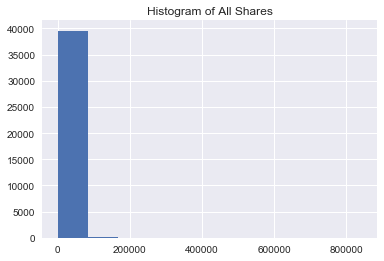

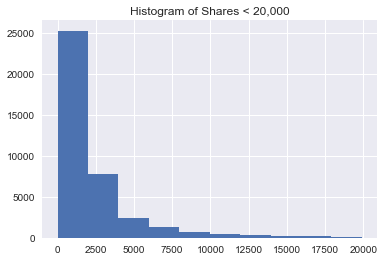

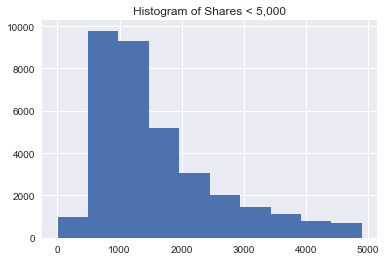

In [9]:
df.hist('shares')
plt.title('Histogram of All Shares')
plt.show()

df[df['shares'] < 20000].hist('shares')
plt.title('Histogram of Shares < 20,000')
plt.show()

df[df['shares'] < 5000].hist('shares')
plt.title('Histogram of Shares < 5,000')
plt.show()

We'll change the shares target to be binary. 0 for <= 1500 shares and 1 for > 1500 shares.

In [10]:
y_train = y_train.map(lambda x: 1 if x > 1500 else 0)
y_test = y_test.map(lambda x: 1 if x > 1500 else 0)

y_train.mean()

0.45760681065741765

~46% of the articles have > 1500 shares. We'll see if we can create a model that can beat the 54% baseline accuracy.

In [11]:
df_train = pd.concat([X_train, y_train], axis=1)

print('Top 10 positively correlated:')
df_train.corr()['shares'].sort_values(ascending=False).to_frame().head(10)

Top 10 positively correlated:


shares
shares                  1.000000
kw_avg_avg              0.168869
is_weekend              0.135119
data_channel_is_socmed  0.105368
weekday_is_saturday     0.103864
num_hrefs               0.093187
kw_min_avg              0.092158
data_channel_is_tech    0.088025
kw_max_avg              0.082922
weekday_is_sunday       0.081336

In [12]:
print('Bottom 10 negatively correlated:')
df_train.corr()['shares'].sort_values(ascending=False).to_frame().tail(10)

Bottom 10 negatively correlated:


shares
average_token_length          -0.027005
kw_max_max                    -0.034570
weekday_is_tuesday            -0.035042
n_tokens_title                -0.040264
weekday_is_wednesday          -0.041705
rate_negative_words           -0.062590
LDA_01                        -0.080157
data_channel_is_entertainment -0.110045
data_channel_is_world         -0.145038
LDA_02                        -0.150130

Nothing seems to be strongly correlated with the shares target.

## Feature Selection

We'll first try eliminating some features through L1 regularization.

#### Regularization

In [13]:
f_cols = df.drop('shares',axis=1).columns

# Scale features
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [14]:
# Fitting with C=0.1
logreg_1 = LogisticRegression(penalty='l1', C=0.1)
logreg_1.fit(X_train, y_train)

# Fitting with C=1.0
logreg_2 = LogisticRegression(penalty='l1', C=1.0)
logreg_2.fit(X_train, y_train)

# Fitting with C=10.0
logreg_3 = LogisticRegression(penalty='l1', C=10.0)
logreg_3.fit(X_train, y_train)

for model_name, model in zip(['C=0.1', 'C=1.0', 'C=10.0'], [logreg_1, logreg_2, logreg_3]):
    print(model_name)
    for col, coef in zip(f_cols, model.coef_[0]):
        if coef == 0.0:
            print('Drop', col, coef)
    print('\n')

C=0.1
Drop n_unique_tokens 0.0
Drop n_non_stop_unique_tokens 0.0
Drop weekday_is_thursday 0.0
Drop weekday_is_sunday 0.0
Drop LDA_03 0.0
Drop global_sentiment_polarity 0.0
Drop rate_positive_words 0.0
Drop min_negative_polarity 0.0


C=1.0
Drop n_unique_tokens 0.0


C=10.0
Drop weekday_is_sunday 0.0




There doesn't look to be a particular trend. We'll now try RFE to see if it can provide better value.

#### RFE

In [15]:
# Use logit as estimator for RFE
logreg = LogisticRegression()
rfe = RFE(logreg)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [16]:
# See which features were eliminated through RFE
for col, keep in zip(f_cols, rfe.support_):
    if keep == False:
        print(col, 'dropped!')

timedelta dropped!
n_tokens_title dropped!
num_imgs dropped!
num_videos dropped!
data_channel_is_lifestyle dropped!
data_channel_is_world dropped!
kw_max_min dropped!
kw_min_max dropped!
self_reference_max_shares dropped!
self_reference_avg_sharess dropped!
weekday_is_monday dropped!
weekday_is_tuesday dropped!
weekday_is_wednesday dropped!
weekday_is_thursday dropped!
LDA_04 dropped!
global_sentiment_polarity dropped!
global_rate_positive_words dropped!
global_rate_negative_words dropped!
rate_positive_words dropped!
rate_negative_words dropped!
avg_positive_polarity dropped!
min_positive_polarity dropped!
max_positive_polarity dropped!
avg_negative_polarity dropped!
min_negative_polarity dropped!
max_negative_polarity dropped!
title_subjectivity dropped!
title_sentiment_polarity dropped!
abs_title_subjectivity dropped!
abs_title_sentiment_polarity dropped!


Seeing some similarities, but RFE also grabbed a lot more columns generally than the regularization. Let's see how select k best performs.

#### SelectKBest

In [17]:
skb = SelectKBest(k=30)
skb.fit(X_train, y_train)

SelectKBest(k=30, score_func=<function f_classif at 0x11a70ed08>)

In [18]:
skb_features = []

for col, keep in zip(f_cols, skb.get_support()):
    if keep == False:
        skb_features.append(col)
        print(col, 'dropped!')

n_tokens_title dropped!
n_unique_tokens dropped!
n_non_stop_words dropped!
n_non_stop_unique_tokens dropped!
num_self_hrefs dropped!
num_videos dropped!
average_token_length dropped!
data_channel_is_lifestyle dropped!
data_channel_is_bus dropped!
kw_max_min dropped!
kw_min_max dropped!
kw_max_max dropped!
kw_avg_max dropped!
weekday_is_monday dropped!
weekday_is_tuesday dropped!
weekday_is_wednesday dropped!
weekday_is_thursday dropped!
weekday_is_friday dropped!
global_rate_negative_words dropped!
rate_positive_words dropped!
avg_positive_polarity dropped!
min_positive_polarity dropped!
max_positive_polarity dropped!
avg_negative_polarity dropped!
min_negative_polarity dropped!
max_negative_polarity dropped!
title_subjectivity dropped!
abs_title_subjectivity dropped!
abs_title_sentiment_polarity dropped!


We can see some patterns of the dropped columns between RFE and SelectKBest. The weekday dummies and polarity features seem to consistently dropped.

#### Comparison Conclusion
In this context, RFE and SelectKBest seem to perform very similarly for eliminating features. Regularization seemed to be more conservative in keeping the features and may be a good starting point when looking at feature selection.

#### Model Compairons

In [19]:
print('Validation Scores-')
print('L1:', logreg_1.score(X_test, y_test))
print('RFE:', rfe.score(X_test, y_test))

# Because our scaled feature matrices are numpy arrays without column
# names, we'll recreate dataframes to filter the columns
X_train_skb_features = pd.DataFrame(X_train, columns=f_cols)[skb_features]
X_test_skb_features = pd.DataFrame(X_test, columns=f_cols)[skb_features]

skb_logreg = LogisticRegression()
skb_logreg.fit(X_train_skb_features, y_train)
skb_score = skb_logreg.score(X_test_skb_features, y_test)
print('SelectKBest:', skb_score)

Validation Scores-
L1: 0.653928616471
RFE: 0.65405473578
SelectKBest: 0.584689115904


The models with RFE and L1 regularization performed almost identically with the model with the features from select k best lagging behind. At this point if I were to choose a model I'd go with the RFE model as it has less complexity and would be easier to interpret. <br/><br/>
As next steps, I'd start gridsearching for best parameters to see how I can boost performance.